In [ ]:
%load_ext autoreload
%autoreload 2

In [137]:
from notebook_utils.utils import *
from notebook_utils.data_generation import *
from pycss.subset_selection import *
from pycss.utils import *
from pycss.PCSS import *
from pycss.CSS import *
from pycss.model_selection import *
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import chi2
from scipy.stats import skewcauchy
from choldate import cholupdate
import multiprocessing
from multiprocessing import Pool
from functools import partial
from tqdm.notebook import tqdm
from pingouin import cronbach_alpha
from rpy2.robjects.conversion import localconverter
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
import rpy2.robjects.numpy2ri as n2r

efa = rpackages.importr('EFAutilities')
n2r.activate()

In [138]:
def cov_df(p):
    return int(p*(p+1)/2)

def model_df(p, k, noise):
    if noise == 'sph':
        return cov_df(k) + (p-k)*k + 1 if k < p else cov_df(p)
    if noise == 'diag':
        return cov_df(k) + (p-k)*(k+ 1)

In [205]:
p = 50
k = 20
n = 5000
B = 5000

#W = get_block_W(p, k, num_blocks=4, block_size=8, overlap=4)

#np.random.seed(0)
#W *= np.random.choice(np.array([-1, 1]), W.shape)
#W*=np.sqrt(1/8)

Ts = []


for i in tqdm(range(B)):
    X_S = np.random.normal(0, 1, (n, k))
    noise = np.random.normal(0, 1, n)
    noise = np.vstack([noise for i in range(p-k)]).T
    noise *= np.random.choice([-1, 1], size=noise.shape)
    X_S_comp =  X_S @ W.T + noise
    #X_S_comp =  X_S @ W.T + (np.random.exponential(1, (n, p-k)) - 1)
    #X_S_comp =  X_S @ W.T + np.random.uniform(-5, 5, (n, p-k))
    X = np.hstack([X_S, X_S_comp])
    _, Sigma_hat = get_moments(X)
    resid = regress_off(Sigma_hat, np.arange(k))[k:, k:]
    T = n * (np.sum(np.log(np.diag(resid))) - np.log(np.linalg.det(resid)))
    Ts.append(T)

x = np.arange(min(Ts), max(Ts), 0.001)
plt.hist(Ts, bins=100, density=True)
plt.plot(x,chi2.pdf(x, df=cov_df(p) - model_df(p, k, 'diag')))
plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

In [4]:
def sample_null(B, n, p, k):
    num_adjusted_samples = n - k # no mean removed 
    num_features = p-k
    full_dfs = np.array([num_adjusted_samples - i + 1 for i in range(1, num_features + 1)])
    full_chi_sqs = np.random.chisquare(df=full_dfs, size=(B, len(full_dfs)))
    null_dfs = np.arange(1, num_features)
    null_chi_sqs = np.random.chisquare(df=null_dfs, size=(B, len(null_dfs)))
    null_chi_sqs = np.hstack([np.zeros(B).reshape((B, 1)), null_chi_sqs])
    return n*(np.sum( np.log(null_chi_sqs/full_chi_sqs + 1), axis=1))


  0%|          | 0/10000 [00:00<?, ?it/s]

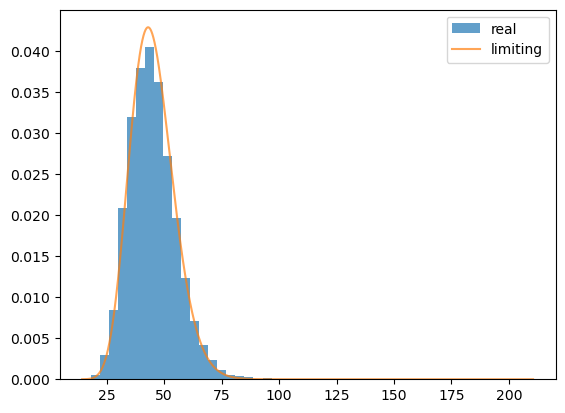

In [10]:
B = 10000
n=5000
p=20
k=10
stats = []
t_df=3
chi_df=3


if (p-k) % 2 == 1:
    print('p-k must be even')

X_S = np.random.uniform(-100, 100, (n, k))
H = X_S @ np.linalg.inv(X_S.T @ X_S) @ X_S.T
P = np.eye(n) - X_S @ np.linalg.inv(X_S.T @ X_S) @ X_S.T

for i in tqdm(range(B)):
    #if t_df == np.inf:
    #    E = np.random.normal(0, 1, size=(n, p-k))
    #else:
    #    E = np.random.standard_t(df=t_df, size=(n, p))
    #E1 = np.random.chisquare(chi_df, size=(n, int((p-k)/2))) - chi_df
    #E2 = np.random.standard_t(df=t_df, size=(n, int((p-k)/2)))
    #E = np.hstack([E1, E2])
    #E = np.random.choice([-1, 1], size=(n, p-k))
    E = np.random.standard_t(df=t_df, size=(n, p-k))
    M = E.T @ E
    #M = E.T @ P @ E
    stats.append( n*(np.sum(np.log(np.diag(M))) - np.log(np.linalg.det(M))) )
plt.hist(stats, bins=50, density=True, label='real', alpha=0.7)
#plt.hist(sample_null(B, n, p, k), bins=50, density=True, label='finite', alpha=0.7)

x = np.arange(min(stats), max(stats), 0.001)
plt.plot(x,chi2.pdf(x, df=int((p-k)*(p-k-1)/2)), label='limiting',alpha=0.7)
plt.legend()


/var/folders/9b/8gtczpzd5_n_zlbsv10125gw0000gn/T/ipykernel_20314/2026935585.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(real_dist, ax=axes[0], color='tab:blue')
/var/folders/9b/8gtczpzd5_n_zlbsv10125gw0000gn/T/ipykernel_20314/2026935585.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplo

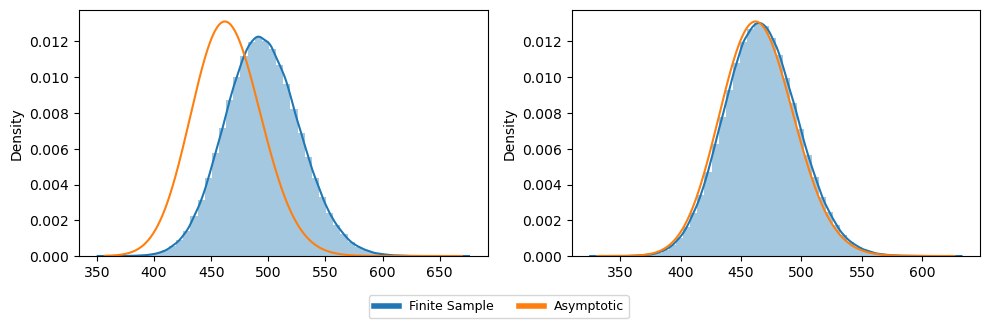

In [140]:
fig, axes = plt.subplots(1, 2, figsize=(10 , 3 ))

p = 50
k = 20
n = 500
real_dist = sample_LRT_stat_under_null(n, p, k, B=int(1e6), noise='sph')
sns.distplot(real_dist, ax=axes[0], color='tab:blue')
x = np.arange(min(real_dist), max(real_dist), 0.001)
sns.lineplot(x=x, y=chi2.pdf(x, df=cov_df(p) - model_df(p, k, 'sph')), ax=axes[0], color='tab:orange')

p = 50
k = 20
n = 5000
real_dist = sample_LRT_stat_under_null(n, p, k, B=int(1e6), noise='sph')
sns.distplot(real_dist, ax=axes[1], color='tab:blue')
x = np.arange(min(real_dist), max(real_dist), 0.001)
sns.lineplot(x=x, y=chi2.pdf(x, df=cov_df(p) - model_df(p, k, 'sph')), ax=axes[1], color='tab:orange')

pivotal_handle, = plt.plot([], [], color='tab:blue', label='Pivotal Dist.', linewidth=4)
wilks_handle, = plt.plot([], [], color='tab:orange', label='Wilks Dist.', linewidth=4)


leg = fig.legend(handles=[pivotal_handle, wilks_handle], prop={'size': 9}, bbox_to_anchor=(0.64, 0.02), ncol=2)  
plt.tight_layout()

#plt.savefig("../figures/pivotal.pdf", bbox_inches='tight')

In [141]:
p = 50
k = 20
C_chol = get_equicorrelated_chol(k, 0.25, diag=1)
C = C_chol @ C_chol.T
sigma_sq = 0.2

W = get_block_W(p, k, num_blocks=4, block_size=8, overlap=4)

np.random.seed(0)
W *= np.random.choice(np.array([-1, 1]), W.shape)
W*np.sqrt(1/8)

D = np.concatenate([np.arange(0.1, 0.8, step=0.1), np.arange(0.1, 0.8, step=0.1), np.arange(0.1, 0.8, step=0.1), np.arange(0.1, 1.0, step=0.1)])
#signal_sizes = np.sum(W * (W @ C), axis=1)
#W = np.sqrt(1 - sigma_sq)/np.sqrt(signal_sizes)[:, None] * W

B = 100
noise = 'diag'
method = 'swap'
num_inits = 50 
ns = [100, 200, 300, 400, 500]
alpha = 0.1

In [ ]:
quantiles = {}

for n in ns:
    for i in range(1, p-1):
        quantiles[(n, p, i, 1 - alpha, noise)] = Q(1 - alpha, n, p, i, noise=noise)

In [5]:
def get_df_from_frames(results_frames):
    
    results_df = pd.DataFrame(results_frames)
    results_df['Type I Error'] = (results_df['Size Selected'] > k).astype(int)
    results_df['% Correct'] = (results_df['Size Selected'] == k).astype(int)
    results_df['Avg. Over'] = results_df['Size Selected'] - k
    results_df.loc[results_df['Avg. Over'] <= 0, 'Avg. Over'] = np.nan
    results_df['Avg. Under'] = k - results_df['Avg. Under'] 
    results_df.loc[results_df['Avg. Under'] <= 0, 'Avg. Under'] = np.nan
    
    return results_df 
    

$X_S$ is Gaussian

In [ ]:
gaussian_results_frames = {'Sample Size' : [], 'Size Selected': []}
for i, n in tqdm(enumerate(ns)):
    gaussian_results_frames['Sample Size'] += list(n * np.ones(B))
    Sigma_hats = generate_gaussian_PCSS_sample_cov(n, C_chol, W, D=D, B=B)
    mp_func = partial(sieves_gaussian_LRT, n=n, alpha=alpha, noise=noise, method=method, num_inits=num_inits, quantiles=quantiles)
    with Pool(multiprocessing.cpu_count()) as pool:
        gaussian_results_frames['Size Selected'] += [len(S) for S in list(tqdm(pool.imap_unordered(mp_func, list(Sigma_hats))))] 
    
gaussian_results_df = get_df_from_frames(gaussian_results_frames)


$X_S$ is ordinal

In [ ]:
ordinal_results_frames = {'Sample Size' : [], 'Size Selected': []}
for i, n in tqdm(enumerate(ns)):
    ordinal_results_frames['Sample Size'] += list(n * np.ones(B)) 
    X_S = np.random.choice(np.array([0, 1, 2, 3, 4]), size=(B, n, k))
    X = generate_PCSS_data(X_S, W, D=D)
    X_c = X - np.mean(X, axis=1)[:, np.newaxis, :]  
    Sigma_hats = 1/n * np.transpose(X_c, (0, 2, 1) ) @ X_c
    mp_func = partial(sieves_gaussian_LRT, n=n, alpha=alpha, noise=noise, method=method, num_inits=num_inits, quantiles=quantiles)
    with Pool(multiprocessing.cpu_count()) as pool:
        ordinal_results_frames['Size Selected'] += [len(S) for S in list(tqdm(pool.imap_unordered(mp_func, list(Sigma_hats))))]
    
ordinal_results_df = get_df_from_frames(ordinal_results_frames)

$X_S$ is skew Cauchy with $a=0.5$

In [8]:
cauchy_results_frames = {'Sample Size' : [], 'Size Selected': []}
for i, n in tqdm(enumerate(ns)):
    cauchy_results_frames['Sample Size'] += list(n * np.ones(B))
    X_S = skewcauchy.rvs(a=0.5, size=(B, n, k))
    X = generate_PCSS_data(X_S, W, D=D)
    X_c = X - np.mean(X, axis=1)[:, np.newaxis, :]  
    Sigma_hats = 1/n * np.transpose(X_c, (0, 2, 1) ) @ X_c
    checked_colinearity = False 
    while not checked_colinearity:
        nothing_complex = True
        for j in range(B):
            if np.iscomplexobj(np.min(np.linalg.eig(Sigma_hats[j, :, :])[0])):
                X_S = skewcauchy.rvs(a=0.5, size=(n, k))
                X = generate_PCSS_data(X_S, W, D=D)
                _, Sigma_hat = get_moments(X)
                Sigma_hats[:, :, j] = Sigma_hat 
                nothing_complex = False
        if nothing_complex:
            checked_colinearity = True   
    mp_func = partial(sieves_gaussian_LRT, n=n, alpha=alpha, noise=noise, method=method, num_inits=num_inits, quantiles=quantiles)
    with Pool(multiprocessing.cpu_count()) as pool:
        cauchy_results_frames['Size Selected'] += [len(S) for S in list(tqdm(pool.imap_unordered(mp_func, list(Sigma_hats))))]
    
cauchy_results_df = get_df_from_frames(cauchy_results_frames)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [168]:
#import pickle
#with open('gaussian_results_df.pickle', 'wb') as f:
#     pickle.dump(gaussian_results_df, f, pickle.HIGHEST_PROTOCOL)
        
#with open('ordinal_results_df.pickle', 'wb') as f:
#     pickle.dump(ordinal_results_df, f, pickle.HIGHEST_PROTOCOL)

#with open('cauchy_results_df.pickle', 'wb') as f:
#     pickle.dump(cauchy_results_df, f, pickle.HIGHEST_PROTOCOL)

gaussian_results_df = pd.read_pickle('gaussian_results_df.pickle')
ordinal_results_df = pd.read_pickle('ordinal_results_df.pickle')
cauchy_results_df = pd.read_pickle('cauchy_results_df.pickle')

gaussian_results_df  = gaussian_results_df.rename(columns={"Excess": "Avg. Over", "Dearth": "Avg. Under", "Power": "% Correct"})
ordinal_results_df  = ordinal_results_df.rename(columns={"Excess": "Avg. Over", "Dearth": "Avg. Under", "Power": "% Correct"})
cauchy_results_df  = cauchy_results_df.rename(columns={"Excess": "Avg. Over", "Dearth": "Avg. Under", "Power": "% Correct"})

/var/folders/9b/8gtczpzd5_n_zlbsv10125gw0000gn/T/ipykernel_75748/2912898315.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  over_df = over_df.append({'Sample Size': n, 'Avg. Over': 0}, ignore_index=True)
/var/folders/9b/8gtczpzd5_n_zlbsv10125gw0000gn/T/ipykernel_75748/2912898315.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  over_df = over_df.append({'Sample Size': n, 'Avg. Over': 0}, ignore_index=True)


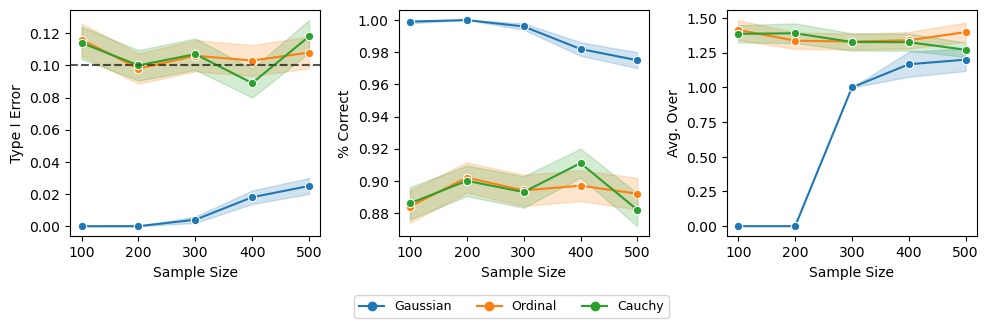

In [169]:
results = {'Gaussian': gaussian_results_df,
          'Ordinal': ordinal_results_df,
          'Cauchy': cauchy_results_df}

dist_to_color = {'Gaussian': 'tab:blue',
                'Ordinal': 'tab:orange',
                'Cauchy': 'tab:green'}

fig, axes = plt.subplots(1, 3, figsize=(10 , 3))

for dist in dist_to_color.keys():
    ## type I error 
    color = dist_to_color[dist]
    
        ## Power
    sns.lineplot(data=results[dist],
                 x='Sample Size', 
                 y='Type I Error', 
                 ax=axes[0], 
                 color=color,
                 marker='o',
                 errorbar=('se', 1))
    axes[0].axhline(alpha, ls='--', c='black', alpha=0.3)
    
    sns.lineplot(data=results[dist],
                 x='Sample Size', 
                 y='% Correct', 
                 ax=axes[1],
                 color=color,
                 marker='o',
                 errorbar=('se', 1))
    
    over_df = results[dist]
    
    over_df = over_df[over_df['Avg. Over'].notnull()]
    over_df = over_df[['Sample Size', 'Avg. Over']]
    for n in ns:
        if n not in set(over_df['Sample Size']):
            over_df = over_df.append({'Sample Size': n, 'Avg. Over': 0}, ignore_index=True)
    sns.lineplot(data=over_df,
                 x='Sample Size', 
                 y='Avg. Over', 
                 ax=axes[2], 
                 color=color,
                 marker='o',
                 errorbar=('se', 1))
    
gaussian_handle, = plt.plot([], [], color='tab:blue', label='Gaussian', marker='o')
ordinal_handle, = plt.plot([], [], color='tab:orange', label='Ordinal', marker='o')
cauchy_handle, = plt.plot([], [], color='tab:green', label='Cauchy', marker='o')

leg = fig.legend(handles=[gaussian_handle, ordinal_handle, cauchy_handle], prop={'size': 9}, bbox_to_anchor=(0.68, 0.02), ncol=3)  

plt.tight_layout()
plt.savefig("../figures/model_selection_sim.pdf", bbox_inches='tight')

### Real Data Analysis

In [6]:
def avg_R2(Sigma, S, standardize=True):
    p = Sigma.shape[0]
    Sigma_R = regress_off(Sigma, S)
    S_comp = complement(p, S)
    resid_var = np.diag(Sigma_R)[S_comp]
    if standardize:
        return 1 - np.mean(np.diag(Sigma_R)[S_comp])
    else:
        var = np.diag(Sigma)[S_comp]
        return np.mean((var - resid_var)/var)

In [7]:
def css_obj_plot(X, k_max, method='greedy', standardize=True, num_inits=1, plot=False):
    
    objs = np.zeros(k_max)
    _, Sigma_hat = get_moments(X)
    
    if standardize:
        Sigma_hat = standardize_cov(Sigma_hat)
    
    css = CSS()
    if method == 'greedy':
        
        css.select_subset_from_cov(Sigma_hat, k_max, method='greedy')
        S_greedy = css.S.copy()
        
        for i in range(1, k_max+1):
            objs[i - 1] = 1 - np.mean(np.diag(regress_off(Sigma_hat, S_greedy[:i])))
            #objs[i - 1] = avg_R2(Sigma_hat, S_greedy[:i], standardize=standardize)
    
    if method == 'swap':
        for i in range(1, k_max + 1):
            best_obj = np.inf
            for j in range(num_inits):
                css.select_subset_from_cov(Sigma_hat, i, method='swap')
                potential_obj = avg_R2(Sigma_hat, css.S, standardize=standardize)
                if potential_obj < best_obj:
                    best_obj = potential_obj
            objs[i - 1] = best_obj
    
    if plot:
        plt.scatter(np.arange(1, k_max + 1), objs)
    
    return objs
        

array([0.07339029, 0.15440559, 0.22502593, 0.29482413, 0.34598087,
       0.39461475, 0.43586328, 0.46774781, 0.49642287, 0.52383401,
       0.55114249, 0.57767783, 0.60085524, 0.6239946 , 0.64554475,
       0.66643342, 0.68611997, 0.7048979 , 0.72346856, 0.74080019,
       0.75682758, 0.77243461, 0.78778183, 0.80278296, 0.81696527,
       0.830897  , 0.84440433, 0.85720053, 0.86964155, 0.88179011,
       0.89378423, 0.904917  , 0.91578994, 0.92587308, 0.93557806,
       0.94472099, 0.95333086, 0.96178558, 0.96975854, 0.97717025,
       0.9832441 , 0.98910376, 0.99486001, 1.        ])

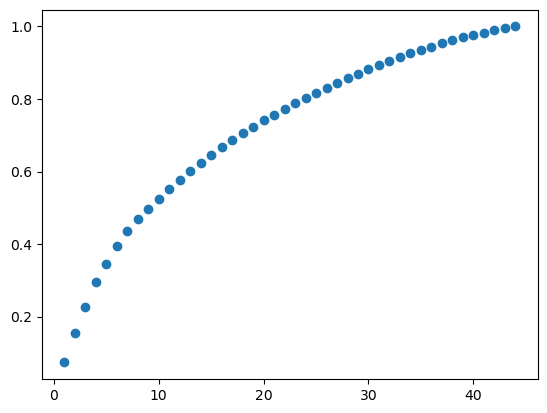

In [8]:
css_obj_plot(X, p, standardize=False, plot=True)

In [120]:
X = pd.read_csv("../data/BFI228.csv").values[:, 1:].astype(int)
n, p = X.shape
_, Sigma_hat = get_moments(X)
n_test = 50
n_train = n - n_test
np.random.seed(0)
train_idxs = np.random.choice(n, n_train, replace=False)
test_idxs = [i for i in range(n) if i not in train_idxs]
X_train = X[train_idxs, :]
_, Sigma_hat_train = get_moments(X_train)

In [121]:
def reverse_columns(X, col_idxs, largest=5):
    for i in col_idxs:
        X[:, i] = -1*(X[:, i] - largest - 1)
    return X

cols = pd.read_csv("../data/BFI228.csv").columns[1:]
reverse_col_idxs = [i for i in range(len(cols)) if cols[i][-1] == 'R']

reversed_X = reverse_columns(X.copy(), reverse_col_idxs)
reversed_X_test = reversed_X[test_idxs, :]

BFI_IDXS = np.arange(p)
BFI_TEN_IDXS = np.sort([1, 12, 21, 27, 42, 7, 8, 17, 33, 37])
BFI_FIFTEEN_IDXS = np.sort([17, 0, 15, 34, 29, 11, 21, 7, 39, 33, 23, 1, 14, 37, 27])
BFI_PORTEGUESE_TWENTY_IDXS = np.sort([0, 7, 4, 1, 14, 11, 9, 16, 21, 20, 18, 17, 33, 28, 31, 30, 38, 34, 41, 36]) 
BFI_NORWEGIAN_TWENTY_IDXS = np.sort([0, 4, 6, 7, 9, 13, 14, 15, 17, 18, 20, 24, 26, 27, 29, 33, 34, 37, 41, 42])
BFI_ENGLISH_TWENTY_IDXS = np.sort([0, 2, 4, 7, 27, 29, 31, 30, 32, 10, 11, 14, 15, 18, 20, 21, 22, 34, 35, 38, 41])

In [122]:
def get_alphas(X, subset_idxs, ci=0.9):
    
    X_subset = X[:, subset_idxs]
    
    EXTRAVERSION_IDXS = np.arange(8)
    AGREEABLENESS_IDXS = np.arange(8, 17)
    CONSCENTIOUSNESS_IDXS = np.arange(17, 26)
    NEUROTICISM_IDXS = np.arange(26, 34)
    OPENNESS_IDXS = np.arange(34, 44)
    
    num_extraversion = len(np.intersect1d(EXTRAVERSION_IDXS, subset_idxs))
    num_agreeableness = len(np.intersect1d(AGREEABLENESS_IDXS, subset_idxs))
    num_conscentiousness = len(np.intersect1d(CONSCENTIOUSNESS_IDXS, subset_idxs))
    num_neuroticism = len(np.intersect1d(NEUROTICISM_IDXS, subset_idxs))
    num_openness = len(np.intersect1d(OPENNESS_IDXS, subset_idxs))
    
    extraversion_subset = np.arange(num_extraversion)
    agreeableness_subset = np.arange(np.max(extraversion_subset) + 1, np.max(extraversion_subset) + 1 + num_agreeableness)
    conscentiousness_subset = np.arange(np.max(agreeableness_subset) + 1, np.max(agreeableness_subset) + 1 + num_conscentiousness)
    neuroticism_subset = np.arange(np.max(conscentiousness_subset) + 1, np.max(conscentiousness_subset) + 1 + num_neuroticism)
    openness_subset = np.arange(np.max(neuroticism_subset) + 1, np.max(neuroticism_subset) + 1 + num_openness)
      
    alpha_dict = {'extraversion': cronbach_alpha(pd.DataFrame(X[:, extraversion_subset])),
                  'agreeableness': cronbach_alpha(pd.DataFrame(X[:, agreeableness_subset])),
                  'conscentiousness': cronbach_alpha(pd.DataFrame(X[:, conscentiousness_subset])),
                  'neuroticism': cronbach_alpha(pd.DataFrame(X[:, neuroticism_subset])),
                  'openness': cronbach_alpha(pd.DataFrame(X[:, openness_subset]))}
    
    return alpha_dict 

In [124]:
alpha=0.1
S = np.sort(sieves_gaussian_LRT(Sigma_hat_train, n_train, alpha, noise='diag', num_inits=100))
print(len(S))
print(S)
print(len(np.where(np.logical_and(S>=0, S<=7))[0]))
print(len(np.where(np.logical_and(S>=8, S<=16))[0]))
print(len(np.where(np.logical_and(S>=17, S<=25))[0]))
print(len(np.where(np.logical_and(S>=26, S<=33))[0]))
print(len(np.where(np.logical_and(S>=34, S<=43))[0]))

19
[ 2  4  7 10 12 13 14 19 20 21 23 27 30 31 33 37 38 41 43]
3
4
4
4
4


In [133]:
S

array([ 2,  4,  7, 10, 12, 13, 14, 19, 20, 21, 23, 27, 30, 31, 33, 37, 38,
       41, 43])

In [125]:
def unpack_alpha_dict(alpha_dict, keys=None):
    if keys is None:
        keys = alpha_dict.keys()
    y_values = [alpha_dict[key][0] for key in keys]
    lower_error_values = [alpha_dict[key][0] - alpha_dict[key][1][0]  for key in keys]
    upper_error_values = [alpha_dict[key][1][1] - alpha_dict[key][0] for key in keys]
    error_values = [lower_error_values, upper_error_values]
    return y_values, error_values 

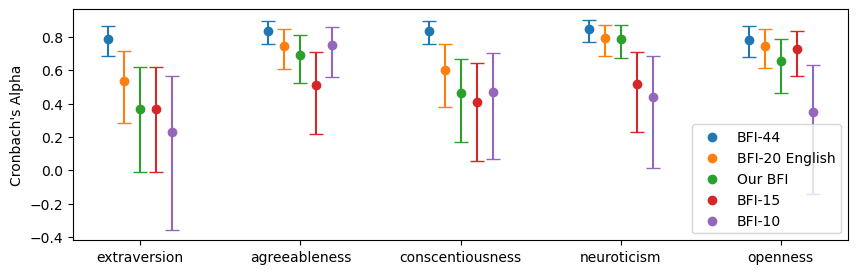

In [129]:
plt.rcParams["figure.figsize"] = (10,3)
x_values = np.arange(5)
x_labels = ['extraversion', 'agreeableness', 'conscentiousness', 'neuroticism', 'openness']
dot_alpha=1
bar_alpha=1

shift = 0.1

#print('BFI')
alpha_dict = get_alphas(reversed_X[test_idxs,  :], BFI_IDXS)
y_values, error_values = unpack_alpha_dict(alpha_dict, keys=x_labels)
plt.scatter(x_values - 2*shift, y_values, label='BFI-44', alpha=dot_alpha)
plt.errorbar(x_values - 2*shift, y_values, yerr=error_values, linestyle="None", capsize=5, alpha=bar_alpha)

#print('BFI 20 - English')
alpha_dict = get_alphas(reversed_X[test_idxs,  :], BFI_ENGLISH_TWENTY_IDXS)
y_values, error_values = unpack_alpha_dict(alpha_dict, keys=x_labels)
plt.scatter(x_values - shift, y_values, label='BFI-20 English', alpha=dot_alpha)
plt.errorbar(x_values - shift, y_values, yerr=error_values, linestyle="None", capsize=5, alpha=bar_alpha)

#print('BFI - Ours')
alpha_dict = get_alphas(reversed_X[test_idxs,  :], S)
y_values, error_values = unpack_alpha_dict(alpha_dict, keys=x_labels)
plt.scatter(x_values, y_values, label='Our BFI', alpha=dot_alpha)
plt.errorbar(x_values, y_values, yerr=error_values, linestyle="None", capsize=5, alpha=bar_alpha)


#print('BFI 15')
alpha_dict = get_alphas(reversed_X[test_idxs,  :], BFI_FIFTEEN_IDXS)
y_values, error_values = unpack_alpha_dict(alpha_dict, keys=x_labels)
plt.scatter(x_values + shift, y_values, label='BFI-15', alpha=dot_alpha)
plt.errorbar(x_values + shift, y_values, yerr=error_values, linestyle="None", capsize=5, alpha=bar_alpha)

#print('BFI 10')
alpha_dict = get_alphas(reversed_X[test_idxs,  :], BFI_TEN_IDXS)
y_values, error_values = unpack_alpha_dict(alpha_dict, keys=x_labels)
plt.scatter(x_values + 2*shift, y_values, label='BFI-10', alpha=dot_alpha)
plt.errorbar(x_values + 2*shift, y_values, yerr=error_values, linestyle="None", capsize=5, alpha=bar_alpha)

#print('BFI 20 - Norwegian')
#alpha_dict = get_alphas(reversed_X[test_idxs,  :], BFI_NORWEGIAN_TWENTY_IDXS)
#y_values, error_values = unpack_alpha_dict(alpha_dict, keys=x_labels)
#plt.scatter(x_values, y_values, label='BFI-20 Norwegian', alpha=dot_alpha)
#plt.errorbar(x_values, y_values, yerr=error_values, linestyle="None", capsize=5, alpha=bar_alpha)

#print('BFI 20 - Porteguese')
#alpha_dict = get_alphas(reversed_X[test_idxs,  :], BFI_PORTEGUESE_TWENTY_IDXS)
#y_values, error_values = unpack_alpha_dict(alpha_dict, keys=x_labels)
#plt.scatter(x_values, y_values, label='BFI-20 Porteguese', alpha=dot_alpha)
#plt.errorbar(x_values, y_values, yerr=error_values, linestyle="None", capsize=5, alpha=bar_alpha)



plt.xticks(x_values, x_labels)
plt.ylabel("Cronbach's Alpha")
plt.legend()

In [135]:
with localconverter(robjects.default_converter + n2r.converter) as cv:
    factor_result = efa.efa(x=X[test_idxs, :][:, S], factors=5)

In [136]:
np.round(factor_result['rotated'], 3)

array([[ 0.379,  0.235, -0.155,  0.207, -0.222],
       [ 0.093, -0.063, -0.136,  0.149,  0.788],
       [ 0.254,  0.073,  0.078, -0.137, -0.432],
       [-0.72 ,  0.051,  0.025, -0.159,  0.037],
       [ 0.571,  0.113, -0.081, -0.071, -0.041],
       [-0.721,  0.152,  0.122, -0.087,  0.199],
       [ 0.846,  0.071,  0.127,  0.092,  0.249],
       [ 0.411,  0.166, -0.39 , -0.196, -0.119],
       [ 0.117,  0.041,  1.003,  0.008, -0.095],
       [-0.14 ,  0.097,  0.448, -0.083,  0.262],
       [ 0.296,  0.158, -0.443,  0.176,  0.074],
       [ 0.04 , -0.008, -0.002,  0.87 ,  0.149],
       [ 0.124,  0.246, -0.26 ,  0.326, -0.261],
       [-0.148, -0.087,  0.094, -0.508,  0.236],
       [ 0.19 , -0.058, -0.167, -0.448,  0.495],
       [-0.08 ,  0.75 ,  0.104,  0.04 , -0.015],
       [-0.078,  0.902, -0.049,  0.049, -0.008],
       [ 0.179,  0.626,  0.095, -0.17 , -0.084],
       [ 0.205,  0.21 , -0.026,  0.195,  0.164]])